# automatyczne ogarnianie ramana


In [1]:
import pandas as pd

# Read data with English column names
data = r"C:\Users\slast\PYTHON\0_projekty do portfolio\04_raman\data\raw\CNT-COOH_a.txt"
df = pd.read_csv(data, sep='\s+', header=None, names=['Wavenumber', 'Intensity'])

print(df.head())
print(df.info())
print(f"\nWavenumber range: {df['Wavenumber'].min()} - {df['Wavenumber'].max()} cm⁻¹")
print(f"Maximum intensity: {df['Intensity'].max()}")

   Wavenumber  Intensity
0     603.157       32.0
1     603.648        6.0
2     604.139       12.0
3     604.629       15.0
4     605.120       15.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7070 entries, 0 to 7069
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Wavenumber  7070 non-null   float64
 1   Intensity   7070 non-null   float64
dtypes: float64(2)
memory usage: 110.6 KB
None

Wavenumber range: 603.157 - 3400.0 cm⁻¹
Maximum intensity: 268.0


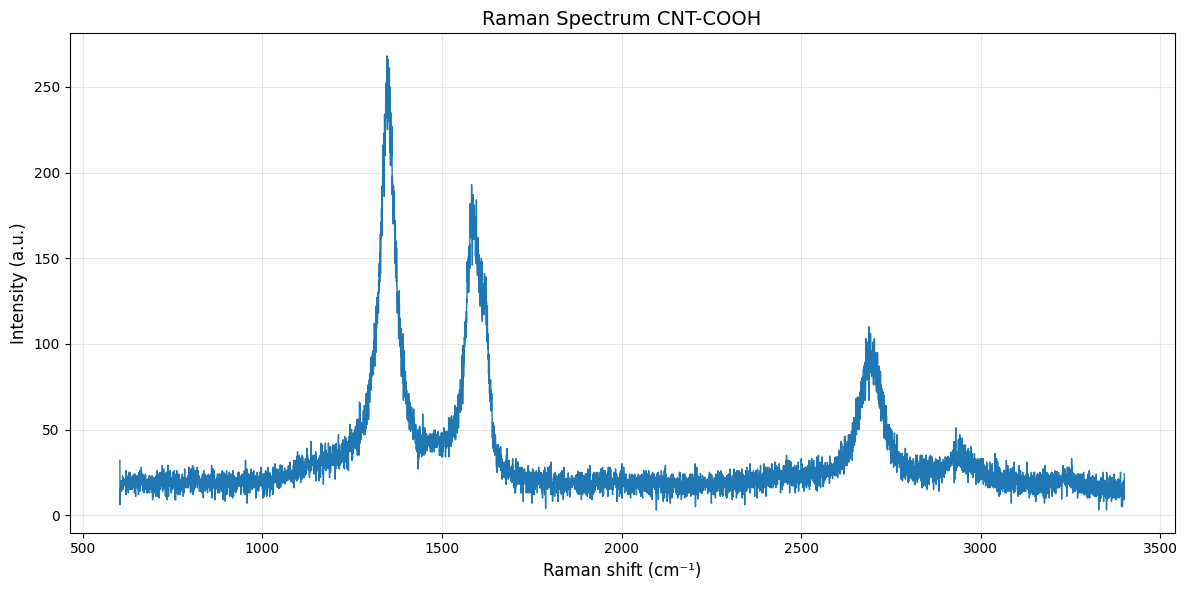

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df['Wavenumber'], df['Intensity'], linewidth=1)
plt.xlabel('Raman shift (cm⁻¹)', fontsize=12)
plt.ylabel('Intensity (a.u.)', fontsize=12)
plt.title('Raman Spectrum CNT-COOH', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [3]:
# Find position of maximum (main peaks)
max_intensity_idx = df['Intensity'].idxmax()
peak_position = df.loc[max_intensity_idx, 'Wavenumber']
peak_intensity = df.loc[max_intensity_idx, 'Intensity']
print(f"Main peak at: {peak_position} cm⁻¹ with intensity: {peak_intensity}")

Main peak at: 1346.56 cm⁻¹ with intensity: 268.0


Found peaks:
Peak 1: 1244.1 cm⁻¹, intensity: 53.0
Peak 2: 1270.4 cm⁻¹, intensity: 66.0
Peak 3: 1346.6 cm⁻¹, intensity: 268.0
Peak 4: 1392.1 cm⁻¹, intensity: 106.0
Peak 5: 1446.4 cm⁻¹, intensity: 59.0
Peak 6: 1536.7 cm⁻¹, intensity: 64.0
Peak 7: 1582.6 cm⁻¹, intensity: 193.0
Peak 8: 1603.9 cm⁻¹, intensity: 152.0
Peak 9: 1626.4 cm⁻¹, intensity: 122.0
Peak 10: 2688.6 cm⁻¹, intensity: 110.0
Peak 11: 2930.7 cm⁻¹, intensity: 51.0


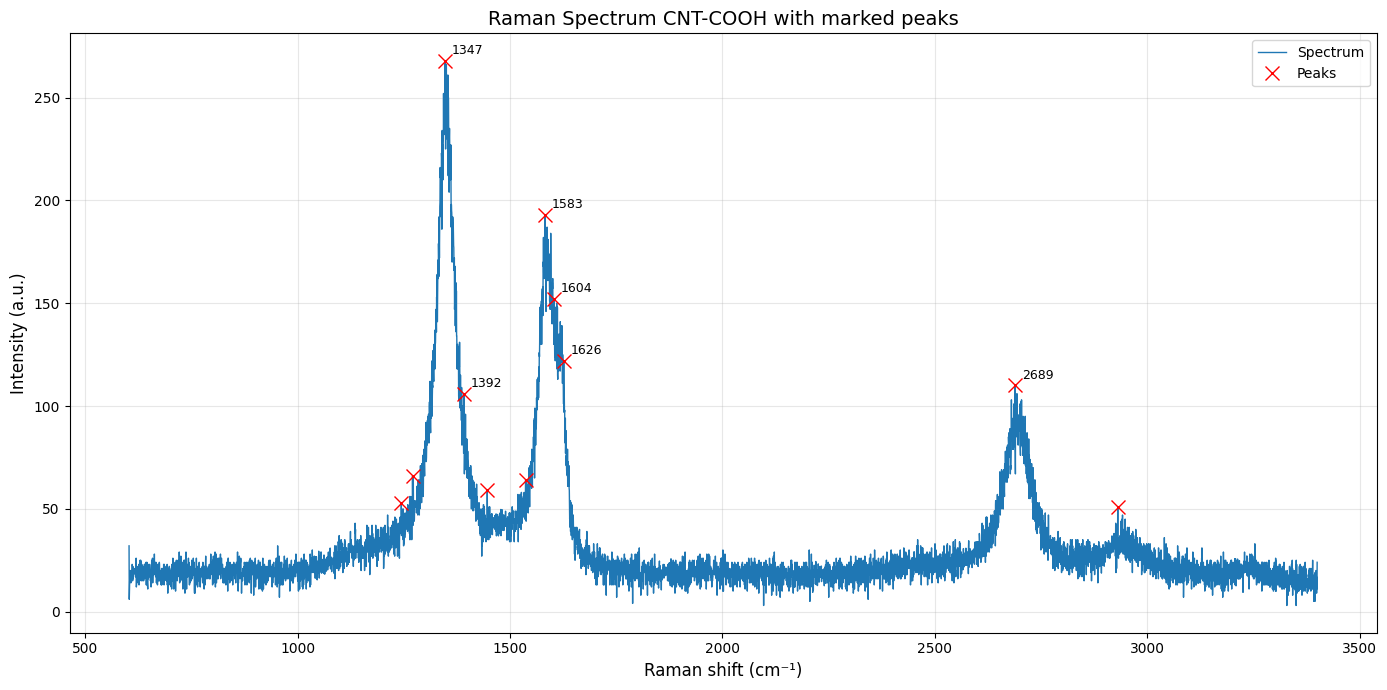


ID/IG ratio: 1.389
(lower value = fewer defects in structure)


In [4]:
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import numpy as np

# Find peaks
peaks, properties = find_peaks(df['Intensity'], height=50, distance=50, prominence=20)

# Display peak information
print("Found peaks:")
for i, peak_idx in enumerate(peaks):
    freq = df.loc[peak_idx, 'Wavenumber']
    intensity = df.loc[peak_idx, 'Intensity']
    print(f"Peak {i+1}: {freq:.1f} cm⁻¹, intensity: {intensity:.1f}")

# Plot with marked peaks
plt.figure(figsize=(14, 7))
plt.plot(df['Wavenumber'], df['Intensity'], linewidth=1, label='Spectrum')
plt.plot(df.loc[peaks, 'Wavenumber'], df.loc[peaks, 'Intensity'], 
         'rx', markersize=10, label='Peaks')

# Annotations for main peaks
for peak_idx in peaks:
    freq = df.loc[peak_idx, 'Wavenumber']
    intensity = df.loc[peak_idx, 'Intensity']
    if intensity > 100:  # Only for larger peaks
        plt.annotate(f'{freq:.0f}', 
                    xy=(freq, intensity), 
                    xytext=(5, 5), 
                    textcoords='offset points',
                    fontsize=9)

plt.xlabel('Raman shift (cm⁻¹)', fontsize=12)
plt.ylabel('Intensity (a.u.)', fontsize=12)
plt.title('Raman Spectrum CNT-COOH with marked peaks', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate ID/IG ratio (material quality)
# Find D (~1350) and G (~1580) bands
d_band = df[(df['Wavenumber'] > 1300) & (df['Wavenumber'] < 1400)]
g_band = df[(df['Wavenumber'] > 1550) & (df['Wavenumber'] < 1650)]

id_ig_ratio = d_band['Intensity'].max() / g_band['Intensity'].max()
print(f"\nID/IG ratio: {id_ig_ratio:.3f}")
print("(lower value = fewer defects in structure)")

# base linee correction

Linear baseline: y = -0.000859x + 16.52


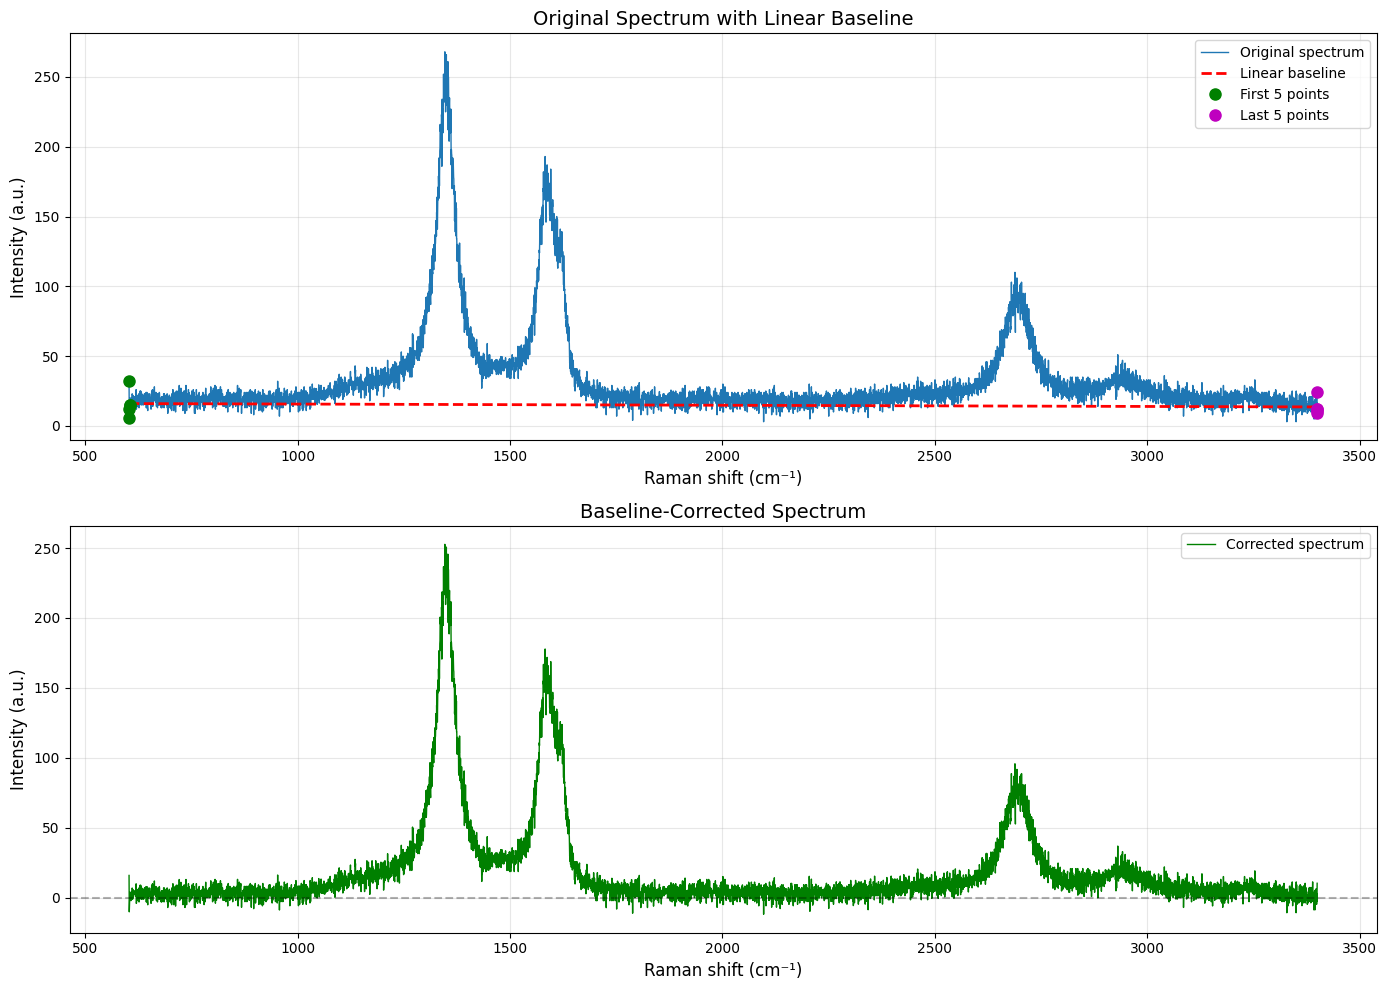

In [5]:
def baseline_linear_endpoints(df, n_points=5):
    """
    Linear baseline correction using first and last n points
    
    Parameters:
    - df: DataFrame with 'Wavenumber' and 'Intensity' columns
    - n_points: number of points to use from each end (default: 5)
    
    Returns:
    - df_corrected: DataFrame with corrected spectrum
    - baseline: calculated linear baseline
    """
    x = df['Wavenumber'].values
    y = df['Intensity'].values
    
    # Take first and last n points
    x_endpoints = np.concatenate([x[:n_points], x[-n_points:]])
    y_endpoints = np.concatenate([y[:n_points], y[-n_points:]])
    
    # Fit linear function: y = ax + b
    coeffs = np.polyfit(x_endpoints, y_endpoints, 1)
    a, b = coeffs
    
    # Calculate baseline for all points
    baseline = a * x + b
    
    # Subtract baseline
    df_corrected = df.copy()
    df_corrected['Intensity'] = y - baseline
    
    print(f"Linear baseline: y = {a:.6f}x + {b:.2f}")
    
    return df_corrected, baseline

# Visualization function
def plot_baseline_correction(df, df_corrected, baseline, n_points=5):
    """
    Plot original spectrum, baseline, and corrected spectrum
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
    
    # Original spectrum with baseline
    ax1.plot(df['Wavenumber'], df['Intensity'], 
             label='Original spectrum', linewidth=1)
    ax1.plot(df['Wavenumber'], baseline, 
             'r--', label='Linear baseline', linewidth=2)
    
    # Mark the points used for fitting
    ax1.plot(df['Wavenumber'].iloc[:n_points], 
             df['Intensity'].iloc[:n_points], 
             'go', markersize=8, label=f'First {n_points} points')
    ax1.plot(df['Wavenumber'].iloc[-n_points:], 
             df['Intensity'].iloc[-n_points:], 
             'mo', markersize=8, label=f'Last {n_points} points')
    
    ax1.set_xlabel('Raman shift (cm⁻¹)', fontsize=12)
    ax1.set_ylabel('Intensity (a.u.)', fontsize=12)
    ax1.set_title('Original Spectrum with Linear Baseline', fontsize=14)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Corrected spectrum
    ax2.plot(df_corrected['Wavenumber'], df_corrected['Intensity'], 
             'g-', label='Corrected spectrum', linewidth=1)
    ax2.axhline(y=0, color='k', linestyle='--', alpha=0.3)
    ax2.set_xlabel('Raman shift (cm⁻¹)', fontsize=12)
    ax2.set_ylabel('Intensity (a.u.)', fontsize=12)
    ax2.set_title('Baseline-Corrected Spectrum', fontsize=14)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Apply correction
df_corrected, baseline = baseline_linear_endpoints(df, n_points=5)
plot_baseline_correction(df, df_corrected, baseline, n_points=5)

# You can change n_points if needed:
# df_corrected, baseline = baseline_linear_endpoints(df, n_points=10)
# plot_baseline_correction(df, df_corrected, baseline, n_points=10)

 # Spectrum normalization 
    Parameters:
    - df: DataFrame with 'Wavenumber' and 'Intensity' columns
    - method: normalization method
        'minmax': scale to [0, 1] range
        'max': divide by maximum value
        'area': normalize by area under curve
        'vector': L2 normalization (unit vector)

Min-Max normalization: scaled to [0, 1]


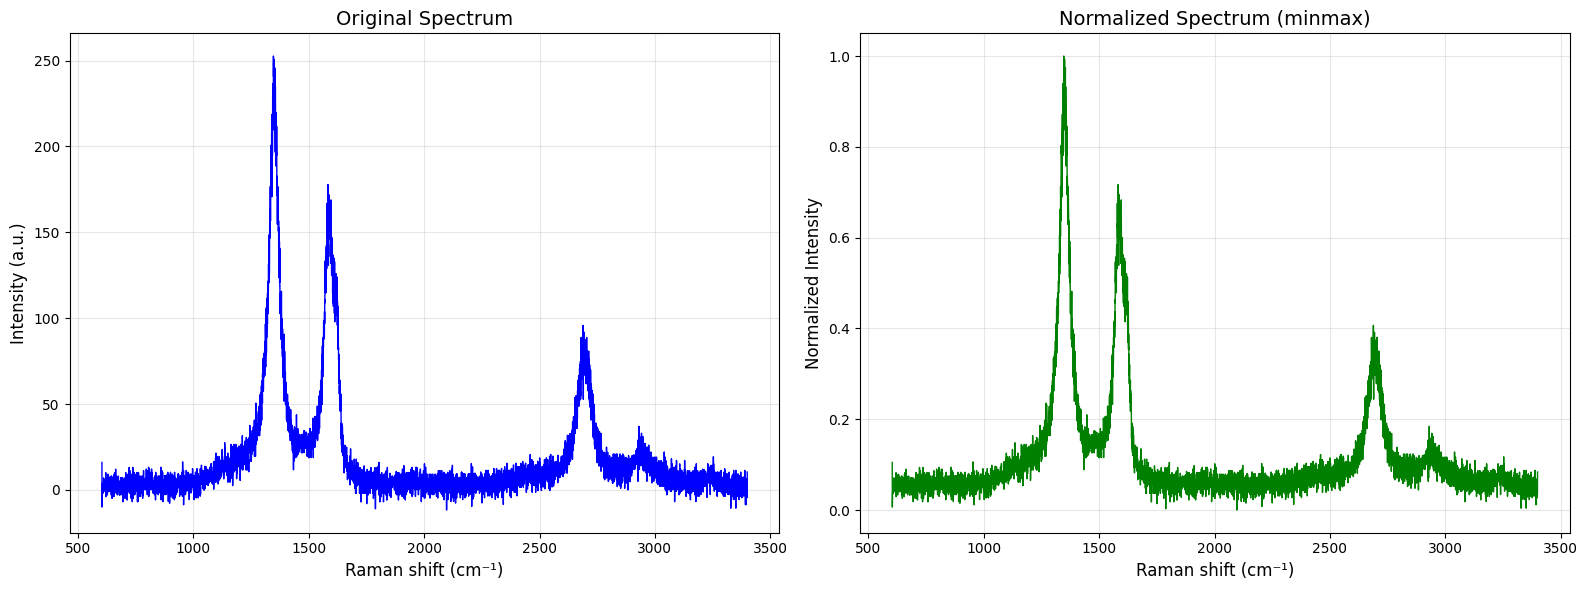


Comparing all normalization methods:
Min-Max normalization: scaled to [0, 1]
Max normalization: divided by max value (252.64)
Area normalization: area under curve = 1 (original area: 52862.11)
Vector normalization: L2 norm = 1 (original norm: 3125.48)


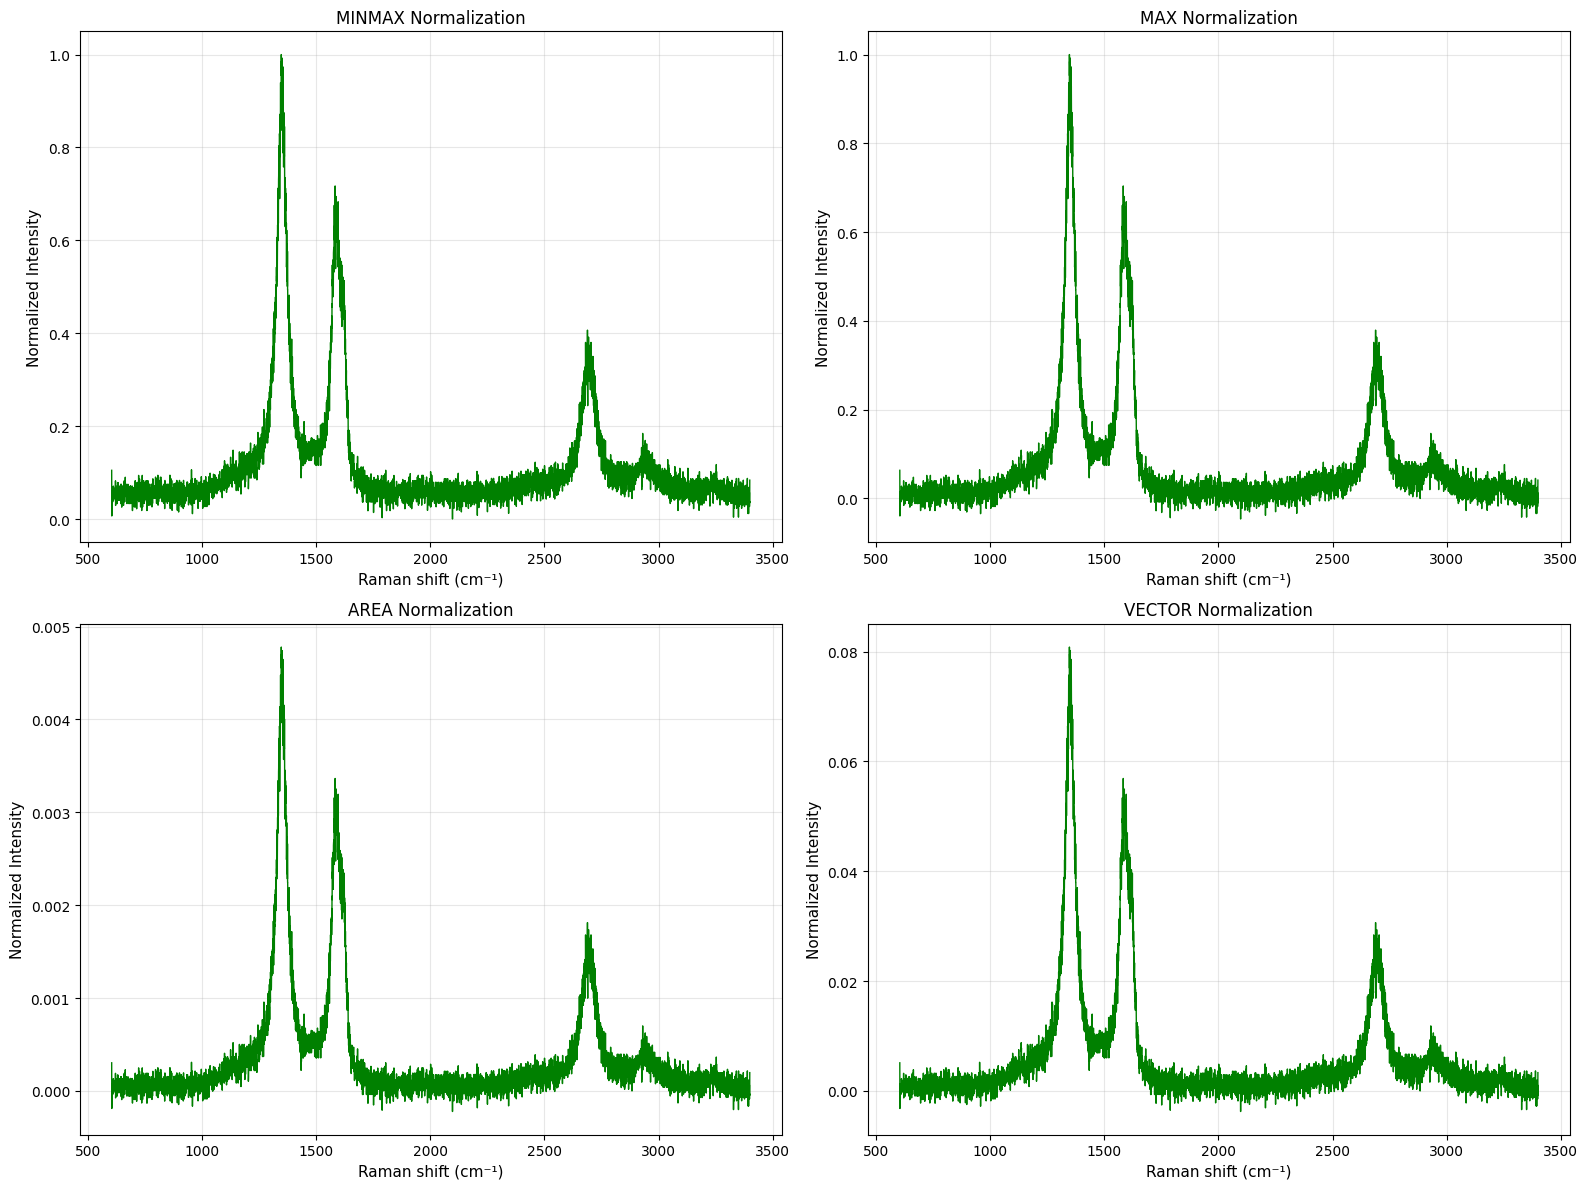

In [6]:
def normalize_spectrum(df, method='minmax'):
    """
    Normalize Raman spectrum
    
    Parameters:
    - df: DataFrame with 'Wavenumber' and 'Intensity' columns
    - method: normalization method
        'minmax': scale to [0, 1] range
        'max': divide by maximum value
        'area': normalize by area under curve
        'vector': L2 normalization (unit vector)
    
    Returns:
    - df_normalized: DataFrame with normalized spectrum
    """
    df_normalized = df.copy()
    intensity = df['Intensity'].values
    
    if method == 'minmax':
        # Scale to [0, 1]
        min_val = intensity.min()
        max_val = intensity.max()
        normalized = (intensity - min_val) / (max_val - min_val)
        print(f"Min-Max normalization: scaled to [0, 1]")
        
    elif method == 'max':
        # Divide by maximum
        max_val = intensity.max()
        normalized = intensity / max_val
        print(f"Max normalization: divided by max value ({max_val:.2f})")
        
    elif method == 'area':
        # Normalize by area under curve
        from scipy.integrate import trapezoid
        area = trapezoid(intensity, df['Wavenumber'].values)
        normalized = intensity / area
        print(f"Area normalization: area under curve = 1 (original area: {area:.2f})")
        
    elif method == 'vector':
        # L2 normalization (unit vector)
        norm = np.linalg.norm(intensity)
        normalized = intensity / norm
        print(f"Vector normalization: L2 norm = 1 (original norm: {norm:.2f})")
        
    else:
        raise ValueError("Method must be 'minmax', 'max', 'area', or 'vector'")
    
    df_normalized['Intensity'] = normalized
    
    return df_normalized

def plot_normalization_comparison(df_original, df_normalized, method):
    """
    Compare original and normalized spectra
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Original spectrum
    ax1.plot(df_original['Wavenumber'], df_original['Intensity'], 
             linewidth=1, color='blue')
    ax1.set_xlabel('Raman shift (cm⁻¹)', fontsize=12)
    ax1.set_ylabel('Intensity (a.u.)', fontsize=12)
    ax1.set_title('Original Spectrum', fontsize=14)
    ax1.grid(True, alpha=0.3)
    
    # Normalized spectrum
    ax2.plot(df_normalized['Wavenumber'], df_normalized['Intensity'], 
             linewidth=1, color='green')
    ax2.set_xlabel('Raman shift (cm⁻¹)', fontsize=12)
    ax2.set_ylabel('Normalized Intensity', fontsize=12)
    ax2.set_title(f'Normalized Spectrum ({method})', fontsize=14)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def plot_multiple_normalizations(df):
    """
    Compare all normalization methods
    """
    methods = ['minmax', 'max', 'area', 'vector']
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    for i, method in enumerate(methods):
        df_norm = normalize_spectrum(df, method=method)
        axes[i].plot(df_norm['Wavenumber'], df_norm['Intensity'], 
                    linewidth=1, color='green')
        axes[i].set_xlabel('Raman shift (cm⁻¹)', fontsize=11)
        axes[i].set_ylabel('Normalized Intensity', fontsize=11)
        axes[i].set_title(f'{method.upper()} Normalization', fontsize=12)
        axes[i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Example usage:

# Method 1: Min-Max normalization (most common)
print("=" * 50)
df_norm_minmax = normalize_spectrum(df_corrected, method='minmax')
plot_normalization_comparison(df_corrected, df_norm_minmax, 'minmax')

# Method 2: Max normalization
# print("=" * 50)
# df_norm_max = normalize_spectrum(df_corrected, method='max')
# plot_normalization_comparison(df_corrected, df_norm_max, 'max')

# Method 3: Area normalization
# print("=" * 50)
# df_norm_area = normalize_spectrum(df_corrected, method='area')
# plot_normalization_comparison(df_corrected, df_norm_area, 'area')

# Method 4: Vector normalization
# print("=" * 50)
# df_norm_vector = normalize_spectrum(df_corrected, method='vector')
# plot_normalization_comparison(df_corrected, df_norm_vector, 'vector')

# Compare all methods at once
print("\n" + "=" * 50)
print("Comparing all normalization methods:")
plot_multiple_normalizations(df_corrected)

## Normalization Methods

### 1. Min-Max Normalization (`minmax`)
Scales the intensity values to the range [0, 1].

**Formula:**
$$I_{norm} = \frac{I - I_{min}}{I_{max} - I_{min}}$$

**Use case:**
- Most common method for Raman spectroscopy
- Good for visual comparison of spectra
- Preserves the shape of the spectrum
- Makes all spectra comparable regardless of absolute intensity

**Advantages:**
- Easy to interpret (0 = minimum, 1 = maximum)
- Good for machine learning algorithms
- Removes intensity variations between measurements

**Disadvantages:**
- Sensitive to outliers
- Minimum value always becomes 0

---

### 2. Max Normalization (`max`)
Divides all intensity values by the maximum intensity.

**Formula:**
$$I_{norm} = \frac{I}{I_{max}}$$

**Use case:**
- Simple and fast normalization
- Good when you want to preserve zero baseline
- Useful for comparing peak ratios (e.g., ID/IG ratio in CNT)

**Advantages:**
- Preserves zero baseline
- Maximum peak always has intensity = 1
- Simple interpretation

**Disadvantages:**
- Sensitive to noise spikes
- One outlier can affect entire spectrum

---

### 3. Area Normalization (`area`)
Normalizes by the total area under the curve (integral).

**Formula:**
$$I_{norm} = \frac{I}{\int I \, d\nu}$$

where $\nu$ is the wavenumber.

**Use case:**
- When comparing spectra with different total scattering intensities
- Useful for quantitative analysis
- Good for comparing relative peak intensities

**Advantages:**
- Accounts for total signal strength
- Good for comparing concentration-dependent measurements
- Preserves peak area ratios

**Disadvantages:**
- More computationally expensive
- Can be affected by baseline issues
- Requires well-defined integration range

---

### 4. Vector (L2) Normalization (`vector`)
Normalizes the intensity vector to unit length (L2 norm = 1).

**Formula:**
$$I_{norm} = \frac{I}{||I||_2} = \frac{I}{\sqrt{\sum I^2}}$$

**Use case:**
- Common in chemometrics and multivariate analysis
- Used in machine learning (e.g., spectral clustering, PCA)
- Good for pattern recognition

**Advantages:**
- Makes all spectra comparable in Euclidean space
- Reduces influence of absolute intensity differences
- Standard in many machine learning algorithms

**Disadvantages:**
- Less intuitive physical interpretation
- All spectral features contribute equally to normalization
- Can emphasize noise in low-intensity regions

---

## Choosing the Right Method

| Method | Best for | Avoid when |
|--------|----------|------------|
| **Min-Max** | Visual comparison, ML preprocessing | Outliers present |
| **Max** | Peak ratio analysis (ID/IG), simple comparison | Noise spikes present |
| **Area** | Quantitative analysis, concentration studies | Poor baseline correction |
| **Vector** | Multivariate analysis, PCA, clustering | Physical interpretation needed |

**Recommendation for CNT Raman spectroscopy:**
- Use **Max normalization** for ID/IG ratio calculations
- Use **Min-Max normalization** for general comparison and visualization
- Use **Vector normalization** for machine learning applications

# Peak Detection and Analysis

Found 236 peaks total
Showing top 11 peaks:
------------------------------------------------------------
Peak 1: 1325.4 cm⁻¹, Intensity: 0.542
Peak 2: 1335.6 cm⁻¹, Intensity: 0.803
Peak 3: 1346.6 cm⁻¹, Intensity: 1.000
Peak 4: 1357.5 cm⁻¹, Intensity: 0.875
Peak 5: 1366.3 cm⁻¹, Intensity: 0.701
Peak 6: 1381.2 cm⁻¹, Intensity: 0.482
Peak 7: 1574.0 cm⁻¹, Intensity: 0.558
Peak 8: 1582.6 cm⁻¹, Intensity: 0.717
Peak 9: 1595.8 cm⁻¹, Intensity: 0.683
Peak 10: 1609.8 cm⁻¹, Intensity: 0.554
Peak 11: 1618.3 cm⁻¹, Intensity: 0.520


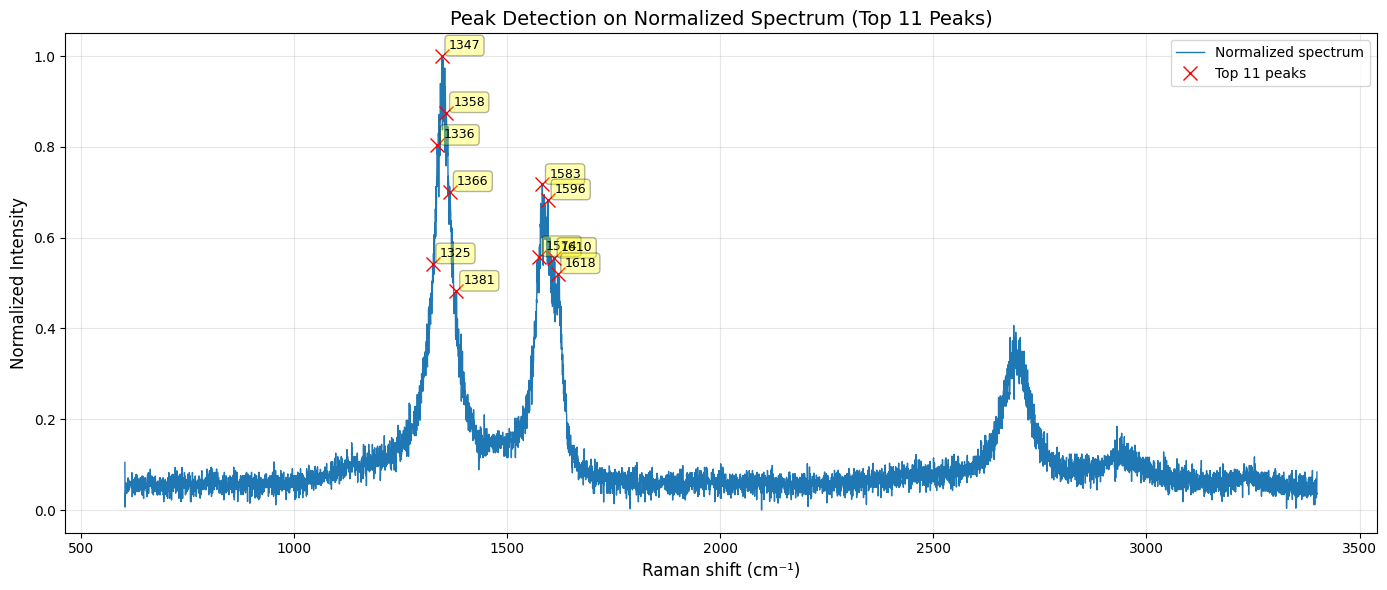


Peak Summary Table:
 Peak  Wavenumber  Intensity
    1     1325.42   0.542214
    2     1335.56   0.803260
    3     1346.56   1.000000
    4     1357.54   0.875204
    5     1366.31   0.701224
    6     1381.19   0.481871
    7     1574.02   0.558153
    8     1582.57   0.717058
    9     1595.80   0.683056
   10     1609.85   0.554487
   11     1618.35   0.520469

Peak Statistics:
Mean peak intensity: 0.676
Std peak intensity: 0.165
Strongest peak: 1346.6 cm⁻¹
Wavenumber range: 1325.4 - 1618.3 cm⁻¹


In [7]:
from scipy.signal import find_peaks

def analyze_peaks(df, n_peaks=11, height=0.1, prominence=0.05, distance=20):
    """
    Find and analyze top n peaks in normalized spectrum
    
    Parameters:
    - df: DataFrame with normalized spectrum
    - n_peaks: number of top peaks to return (default: 11)
    - height: minimum peak height
    - prominence: minimum peak prominence
    - distance: minimum distance between peaks
    """
    # Find all peaks
    peaks, properties = find_peaks(df['Intensity'], 
                                   height=height, 
                                   prominence=prominence,
                                   distance=distance)
    
    # Get peak intensities
    peak_intensities = df.loc[peaks, 'Intensity'].values
    
    # Sort peaks by intensity and take top n_peaks
    sorted_indices = np.argsort(peak_intensities)[::-1]  # Descending order
    top_peaks = peaks[sorted_indices[:n_peaks]]
    
    # Sort top peaks by wavenumber for display
    top_peaks = np.sort(top_peaks)
    
    print(f"Found {len(peaks)} peaks total")
    print(f"Showing top {min(n_peaks, len(peaks))} peaks:")
    print("-" * 60)
    
    peak_data = []
    for i, peak_idx in enumerate(top_peaks):
        wavenumber = df.loc[peak_idx, 'Wavenumber']
        intensity = df.loc[peak_idx, 'Intensity']
        peak_data.append({
            'Peak': i+1, 
            'Wavenumber': wavenumber, 
            'Intensity': intensity
        })
        print(f"Peak {i+1}: {wavenumber:.1f} cm⁻¹, Intensity: {intensity:.3f}")
    
    return top_peaks, pd.DataFrame(peak_data)

# Analyze peaks (top 11)
peaks, peak_df = analyze_peaks(df_norm_minmax, n_peaks=11, height=0.05, prominence=0.03)

# Visualize
plt.figure(figsize=(14, 6))
plt.plot(df_norm_minmax['Wavenumber'], df_norm_minmax['Intensity'], 
         linewidth=1, label='Normalized spectrum')
plt.plot(df_norm_minmax.loc[peaks, 'Wavenumber'], 
         df_norm_minmax.loc[peaks, 'Intensity'], 
         'rx', markersize=10, label=f'Top {len(peaks)} peaks')

# Annotate all detected peaks
for peak_idx in peaks:
    wn = df_norm_minmax.loc[peak_idx, 'Wavenumber']
    intensity = df_norm_minmax.loc[peak_idx, 'Intensity']
    plt.annotate(f'{wn:.0f}', 
                xy=(wn, intensity), 
                xytext=(5, 5), 
                textcoords='offset points', 
                fontsize=9,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.3))

plt.xlabel('Raman shift (cm⁻¹)', fontsize=12)
plt.ylabel('Normalized Intensity', fontsize=12)
plt.title(f'Peak Detection on Normalized Spectrum (Top {len(peaks)} Peaks)', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Display peak table
print("\n" + "=" * 60)
print("Peak Summary Table:")
print("=" * 60)
print(peak_df.to_string(index=False))

# Additional statistics
print("\n" + "=" * 60)
print("Peak Statistics:")
print("=" * 60)
print(f"Mean peak intensity: {peak_df['Intensity'].mean():.3f}")
print(f"Std peak intensity: {peak_df['Intensity'].std():.3f}")
print(f"Strongest peak: {peak_df.loc[peak_df['Intensity'].idxmax(), 'Wavenumber']:.1f} cm⁻¹")
print(f"Wavenumber range: {peak_df['Wavenumber'].min():.1f} - {peak_df['Wavenumber'].max():.1f} cm⁻¹")

In [ ]:
from scipy.signal import find_peaks
from adjustText import adjust_text  # pip install adjustText if needed

def analyze_peaks_improved(df, n_peaks=11, height=0.1, prominence=0.05, distance=20):
    """
    Find and analyze top n peaks with improved visualization
    """
    peaks, properties = find_peaks(df['Intensity'], 
                                   height=height, 
                                   prominence=prominence,
                                   distance=distance)
    
    peak_intensities = df.loc[peaks, 'Intensity'].values
    sorted_indices = np.argsort(peak_intensities)[::-1]
    top_peaks = peaks[sorted_indices[:n_peaks]]
    top_peaks = np.sort(top_peaks)
    
    print(f"Top {len(top_peaks)} peaks detected:")
    print("-" * 60)
    
    peak_data = []
    for i, peak_idx in enumerate(top_peaks):
        wavenumber = df.loc[peak_idx, 'Wavenumber']
        intensity = df.loc[peak_idx, 'Intensity']
        peak_data.append({
            'Peak': i+1, 
            'Wavenumber': wavenumber, 
            'Intensity': intensity
        })
        print(f"Peak {i+1}: {wavenumber:.1f} cm⁻¹, Intensity: {intensity:.3f}")
    
    return top_peaks, pd.DataFrame(peak_data)

# Detect peaks
peaks, peak_df = analyze_peaks_improved(df_norm_minmax, n_peaks=11, 
                                        height=0.1, prominence=0.05, distance=20)

# Improved visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))

# Full spectrum with peaks
ax1.plot(df_norm_minmax['Wavenumber'], df_norm_minmax['Intensity'], 
         linewidth=1, label='Normalized spectrum', color='blue')
ax1.plot(df_norm_minmax.loc[peaks, 'Wavenumber'], 
         df_norm_minmax.loc[peaks, 'Intensity'], 
         'rx', markersize=12, markeredgewidth=2, label=f'Top {len(peaks)} peaks')

# Add vertical lines for peaks
for peak_idx in peaks:
    wn = df_norm_minmax.loc[peak_idx, 'Wavenumber']
    intensity = df_norm_minmax.loc[peak_idx, 'Intensity']
    ax1.axvline(wn, color='red', linestyle='--', alpha=0.3, linewidth=0.8)
    ax1.text(wn, intensity + 0.05, f'{wn:.0f}', 
            rotation=90, fontsize=9, ha='center', va='bottom')

ax1.set_xlabel('Raman shift (cm⁻¹)', fontsize=12)
ax1.set_ylabel('Normalized Intensity', fontsize=12)
ax1.set_title(f'Peak Detection - Full Spectrum (Top {len(peaks)} Peaks)', fontsize=14)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_ylim(-0.05, 1.15)

# Zoomed view of D and G bands (1200-1700 cm⁻¹)
zoom_df = df_norm_minmax[(df_norm_minmax['Wavenumber'] >= 1200) & 
                          (df_norm_minmax['Wavenumber'] <= 1800)]
zoom_peaks = [p for p in peaks if 1200 <= df_norm_minmax.loc[p, 'Wavenumber'] <= 1800]

ax2.plot(zoom_df['Wavenumber'], zoom_df['Intensity'], 
         linewidth=1.5, label='Normalized spectrum', color='blue')
ax2.plot(df_norm_minmax.loc[zoom_peaks, 'Wavenumber'], 
         df_norm_minmax.loc[zoom_peaks, 'Intensity'], 
         'rx', markersize=12, markeredgewidth=2, label='Detected peaks')

# Annotate zoomed peaks
for peak_idx in zoom_peaks:
    wn = df_norm_minmax.loc[peak_idx, 'Wavenumber']
    intensity = df_norm_minmax.loc[peak_idx, 'Intensity']
    ax2.annotate(f'{wn:.0f}', 
                xy=(wn, intensity), 
                xytext=(0, 15), 
                textcoords='offset points',
                fontsize=10,
                ha='center',
                bbox=dict(boxstyle='round,pad=0.4', facecolor='yellow', alpha=0.7),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', 
                              color='black', lw=1))

ax2.set_xlabel('Raman shift (cm⁻¹)', fontsize=12)
ax2.set_ylabel('Normalized Intensity', fontsize=12)
ax2.set_title('Zoomed View: D and G Band Region (1200-1800 cm⁻¹)', fontsize=14)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print peak table
print("\n" + "=" * 60)
print("Peak Summary Table:")
print("=" * 60)
print(peak_df.to_string(index=False))

ModuleNotFoundError: No module named 'adjustText'

Found 10 peaks total
Showing top 10 peaks:
------------------------------------------------------------
Peak 1: 1270.4 cm⁻¹, Intensity: 0.236
Peak 2: 1346.6 cm⁻¹, Intensity: 1.000
Peak 3: 1392.1 cm⁻¹, Intensity: 0.387
Peak 4: 1446.4 cm⁻¹, Intensity: 0.210
Peak 5: 1582.6 cm⁻¹, Intensity: 0.717
Peak 6: 1603.9 cm⁻¹, Intensity: 0.562
Peak 7: 2688.6 cm⁻¹, Intensity: 0.407
Peak 8: 2712.8 cm⁻¹, Intensity: 0.350
Peak 9: 2731.4 cm⁻¹, Intensity: 0.256
Peak 10: 2930.7 cm⁻¹, Intensity: 0.184


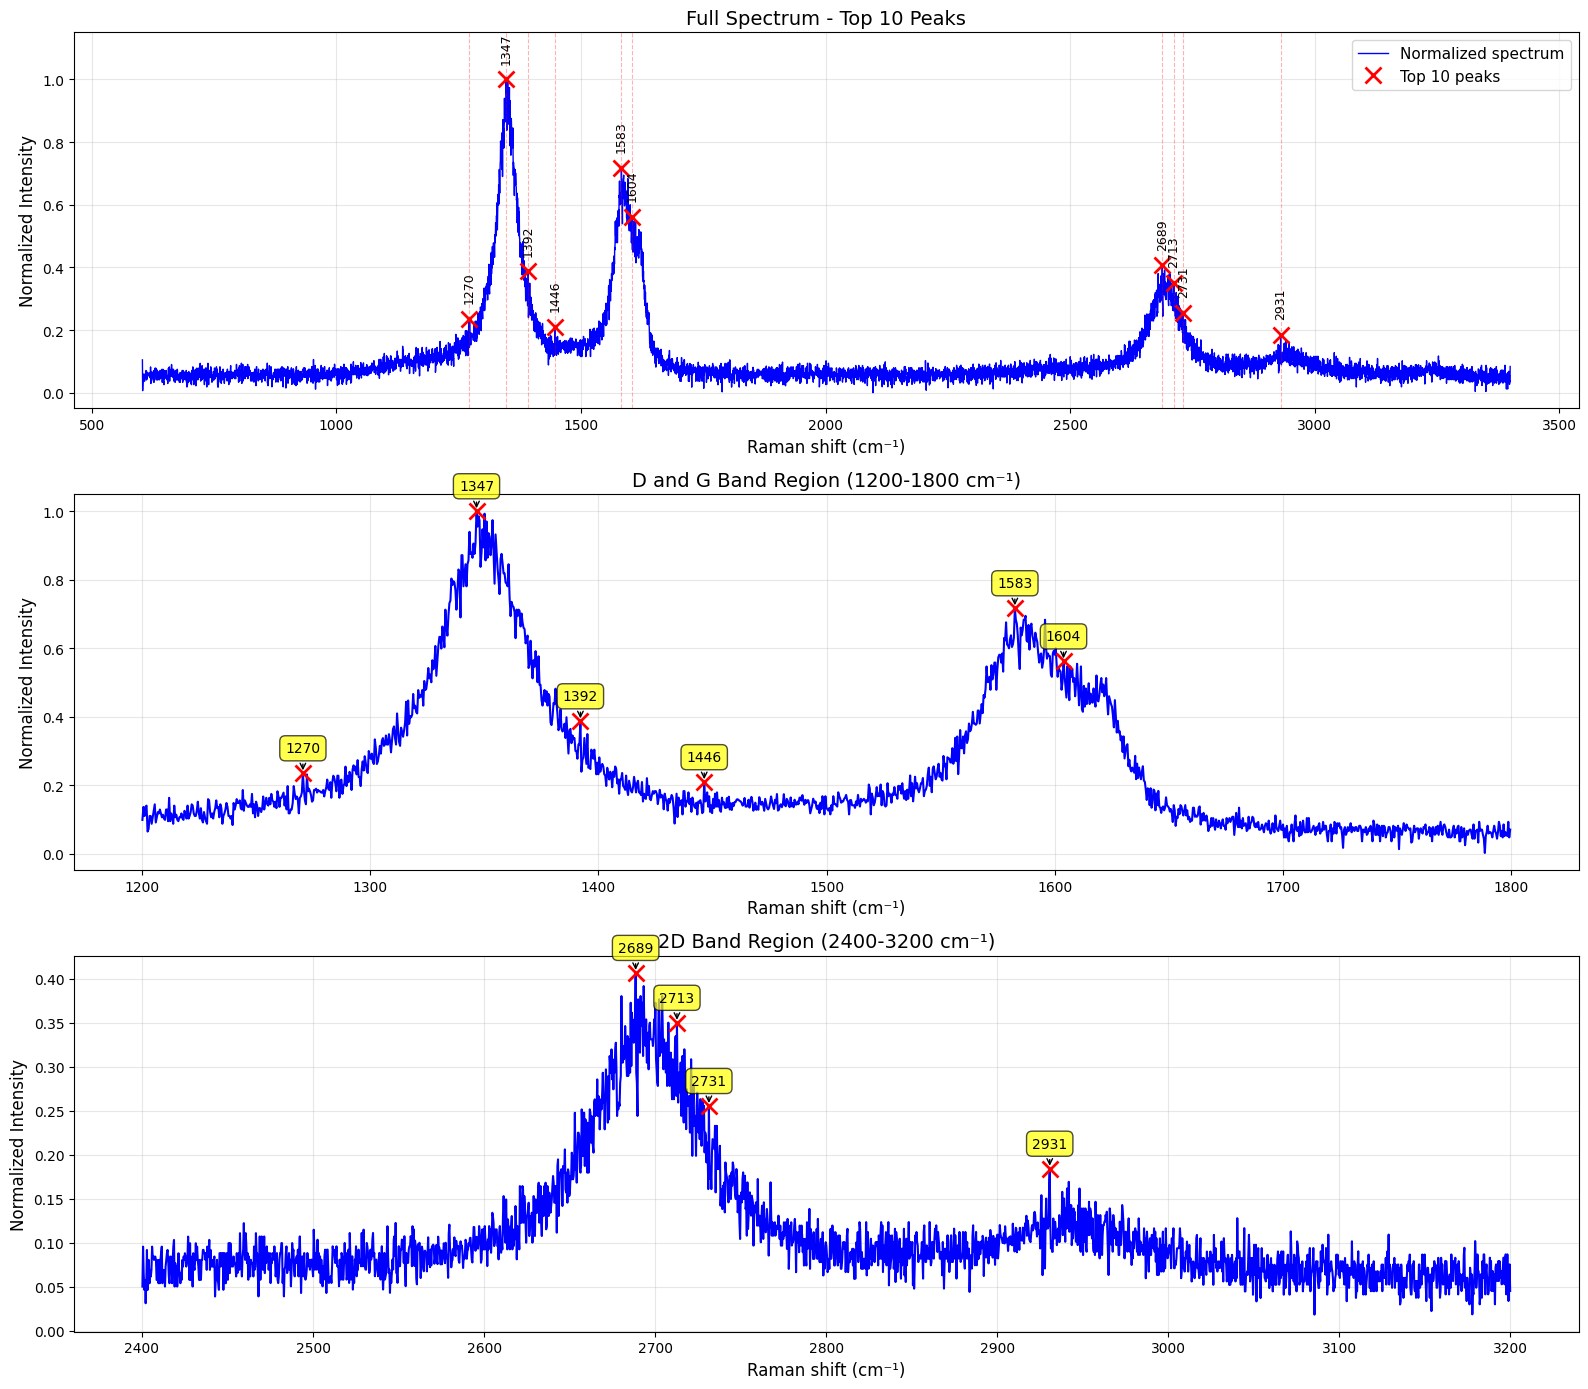


Peak Summary Table:
 Peak  Wavenumber  Intensity
    1     1270.44   0.235630
    2     1346.56   1.000000
    3     1392.11   0.387337
    4     1446.39   0.209722
    5     1582.57   0.717058
    6     1603.90   0.562033
    7     2688.60   0.406680
    8     2712.75   0.350016
    9     2731.42   0.255507
   10     2930.67   0.184282

Peaks by Region:

D-band region (1200-1450 cm⁻¹): 4 peak(s)
  1270.4 cm⁻¹ - Intensity: 0.236
  1346.6 cm⁻¹ - Intensity: 1.000
  1392.1 cm⁻¹ - Intensity: 0.387
  1446.4 cm⁻¹ - Intensity: 0.210

G-band region (1450-1800 cm⁻¹): 2 peak(s)
  1582.6 cm⁻¹ - Intensity: 0.717
  1603.9 cm⁻¹ - Intensity: 0.562

2D-band region (2400-3200 cm⁻¹): 4 peak(s)
  2688.6 cm⁻¹ - Intensity: 0.407
  2712.8 cm⁻¹ - Intensity: 0.350
  2731.4 cm⁻¹ - Intensity: 0.256
  2930.7 cm⁻¹ - Intensity: 0.184


In [10]:
from scipy.signal import find_peaks

def analyze_peaks(df, n_peaks=11, height=0.15, prominence=0.08, distance=50):
    """
    Find and analyze top n peaks in normalized spectrum
    
    Parameters adjusted for CNT Raman spectroscopy:
    - height=0.15: higher threshold to avoid noise
    - prominence=0.08: requires peaks to be distinct
    - distance=50: allows wider spacing to catch separated peaks (D, G, 2D bands)
    """
    # Find all peaks
    peaks, properties = find_peaks(df['Intensity'], 
                                   height=height, 
                                   prominence=prominence,
                                   distance=distance)
    
    # Get peak intensities
    peak_intensities = df.loc[peaks, 'Intensity'].values
    
    # Sort peaks by intensity and take top n_peaks
    sorted_indices = np.argsort(peak_intensities)[::-1]  # Descending order
    top_peaks = peaks[sorted_indices[:min(n_peaks, len(peaks))]]
    
    # Sort top peaks by wavenumber for display
    top_peaks = np.sort(top_peaks)
    
    print(f"Found {len(peaks)} peaks total")
    print(f"Showing top {len(top_peaks)} peaks:")
    print("-" * 60)
    
    peak_data = []
    for i, peak_idx in enumerate(top_peaks):
        wavenumber = df.loc[peak_idx, 'Wavenumber']
        intensity = df.loc[peak_idx, 'Intensity']
        peak_data.append({
            'Peak': i+1, 
            'Wavenumber': wavenumber, 
            'Intensity': intensity
        })
        print(f"Peak {i+1}: {wavenumber:.1f} cm⁻¹, Intensity: {intensity:.3f}")
    
    return top_peaks, pd.DataFrame(peak_data)

# Analyze peaks with adjusted parameters
peaks, peak_df = analyze_peaks(df_norm_minmax, n_peaks=11, 
                               height=0.15, prominence=0.08, distance=50)

# Visualize
fig, axes = plt.subplots(3, 1, figsize=(16, 14))

# 1. Full spectrum
axes[0].plot(df_norm_minmax['Wavenumber'], df_norm_minmax['Intensity'], 
             linewidth=1, label='Normalized spectrum', color='blue')
axes[0].plot(df_norm_minmax.loc[peaks, 'Wavenumber'], 
             df_norm_minmax.loc[peaks, 'Intensity'], 
             'rx', markersize=12, markeredgewidth=2, label=f'Top {len(peaks)} peaks')

for peak_idx in peaks:
    wn = df_norm_minmax.loc[peak_idx, 'Wavenumber']
    intensity = df_norm_minmax.loc[peak_idx, 'Intensity']
    axes[0].axvline(wn, color='red', linestyle='--', alpha=0.3, linewidth=0.8)
    axes[0].text(wn, intensity + 0.05, f'{wn:.0f}', 
                rotation=90, fontsize=9, ha='center', va='bottom')

axes[0].set_xlabel('Raman shift (cm⁻¹)', fontsize=12)
axes[0].set_ylabel('Normalized Intensity', fontsize=12)
axes[0].set_title(f'Full Spectrum - Top {len(peaks)} Peaks', fontsize=14)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim(-0.05, 1.15)

# 2. Zoomed: D and G bands (1200-1800 cm⁻¹)
zoom1_df = df_norm_minmax[(df_norm_minmax['Wavenumber'] >= 1200) & 
                           (df_norm_minmax['Wavenumber'] <= 1800)]
zoom1_peaks = [p for p in peaks if 1200 <= df_norm_minmax.loc[p, 'Wavenumber'] <= 1800]

axes[1].plot(zoom1_df['Wavenumber'], zoom1_df['Intensity'], 
             linewidth=1.5, color='blue')
axes[1].plot(df_norm_minmax.loc[zoom1_peaks, 'Wavenumber'], 
             df_norm_minmax.loc[zoom1_peaks, 'Intensity'], 
             'rx', markersize=12, markeredgewidth=2)

for peak_idx in zoom1_peaks:
    wn = df_norm_minmax.loc[peak_idx, 'Wavenumber']
    intensity = df_norm_minmax.loc[peak_idx, 'Intensity']
    axes[1].annotate(f'{wn:.0f}', 
                    xy=(wn, intensity), 
                    xytext=(0, 15), 
                    textcoords='offset points',
                    fontsize=10,
                    ha='center',
                    bbox=dict(boxstyle='round,pad=0.4', facecolor='yellow', alpha=0.7),
                    arrowprops=dict(arrowstyle='->', color='black', lw=1))

axes[1].set_xlabel('Raman shift (cm⁻¹)', fontsize=12)
axes[1].set_ylabel('Normalized Intensity', fontsize=12)
axes[1].set_title('D and G Band Region (1200-1800 cm⁻¹)', fontsize=14)
axes[1].grid(True, alpha=0.3)

# 3. Zoomed: 2D band region (2400-3200 cm⁻¹)
zoom2_df = df_norm_minmax[(df_norm_minmax['Wavenumber'] >= 2400) & 
                           (df_norm_minmax['Wavenumber'] <= 3200)]
zoom2_peaks = [p for p in peaks if 2400 <= df_norm_minmax.loc[p, 'Wavenumber'] <= 3200]

axes[2].plot(zoom2_df['Wavenumber'], zoom2_df['Intensity'], 
             linewidth=1.5, color='blue')
axes[2].plot(df_norm_minmax.loc[zoom2_peaks, 'Wavenumber'], 
             df_norm_minmax.loc[zoom2_peaks, 'Intensity'], 
             'rx', markersize=12, markeredgewidth=2)

for peak_idx in zoom2_peaks:
    wn = df_norm_minmax.loc[peak_idx, 'Wavenumber']
    intensity = df_norm_minmax.loc[peak_idx, 'Intensity']
    axes[2].annotate(f'{wn:.0f}', 
                    xy=(wn, intensity), 
                    xytext=(0, 15), 
                    textcoords='offset points',
                    fontsize=10,
                    ha='center',
                    bbox=dict(boxstyle='round,pad=0.4', facecolor='yellow', alpha=0.7),
                    arrowprops=dict(arrowstyle='->', color='black', lw=1))

axes[2].set_xlabel('Raman shift (cm⁻¹)', fontsize=12)
axes[2].set_ylabel('Normalized Intensity', fontsize=12)
axes[2].set_title('2D Band Region (2400-3200 cm⁻¹)', fontsize=14)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Display peak table
print("\n" + "=" * 60)
print("Peak Summary Table:")
print("=" * 60)
print(peak_df.to_string(index=False))

# Categorize peaks
def categorize_peaks(peak_df):
    print("\n" + "=" * 60)
    print("Peaks by Region:")
    print("=" * 60)
    
    d_peaks = peak_df[(peak_df['Wavenumber'] >= 1200) & (peak_df['Wavenumber'] < 1450)]
    g_peaks = peak_df[(peak_df['Wavenumber'] >= 1450) & (peak_df['Wavenumber'] < 1800)]
    band_2d = peak_df[(peak_df['Wavenumber'] >= 2400) & (peak_df['Wavenumber'] < 3200)]
    
    if len(d_peaks) > 0:
        print(f"\nD-band region (1200-1450 cm⁻¹): {len(d_peaks)} peak(s)")
        for _, row in d_peaks.iterrows():
            print(f"  {row['Wavenumber']:.1f} cm⁻¹ - Intensity: {row['Intensity']:.3f}")
    
    if len(g_peaks) > 0:
        print(f"\nG-band region (1450-1800 cm⁻¹): {len(g_peaks)} peak(s)")
        for _, row in g_peaks.iterrows():
            print(f"  {row['Wavenumber']:.1f} cm⁻¹ - Intensity: {row['Intensity']:.3f}")
    
    if len(band_2d) > 0:
        print(f"\n2D-band region (2400-3200 cm⁻¹): {len(band_2d)} peak(s)")
        for _, row in band_2d.iterrows():
            print(f"  {row['Wavenumber']:.1f} cm⁻¹ - Intensity: {row['Intensity']:.3f}")

categorize_peaks(peak_df)

FITTING D AND G BAND REGION



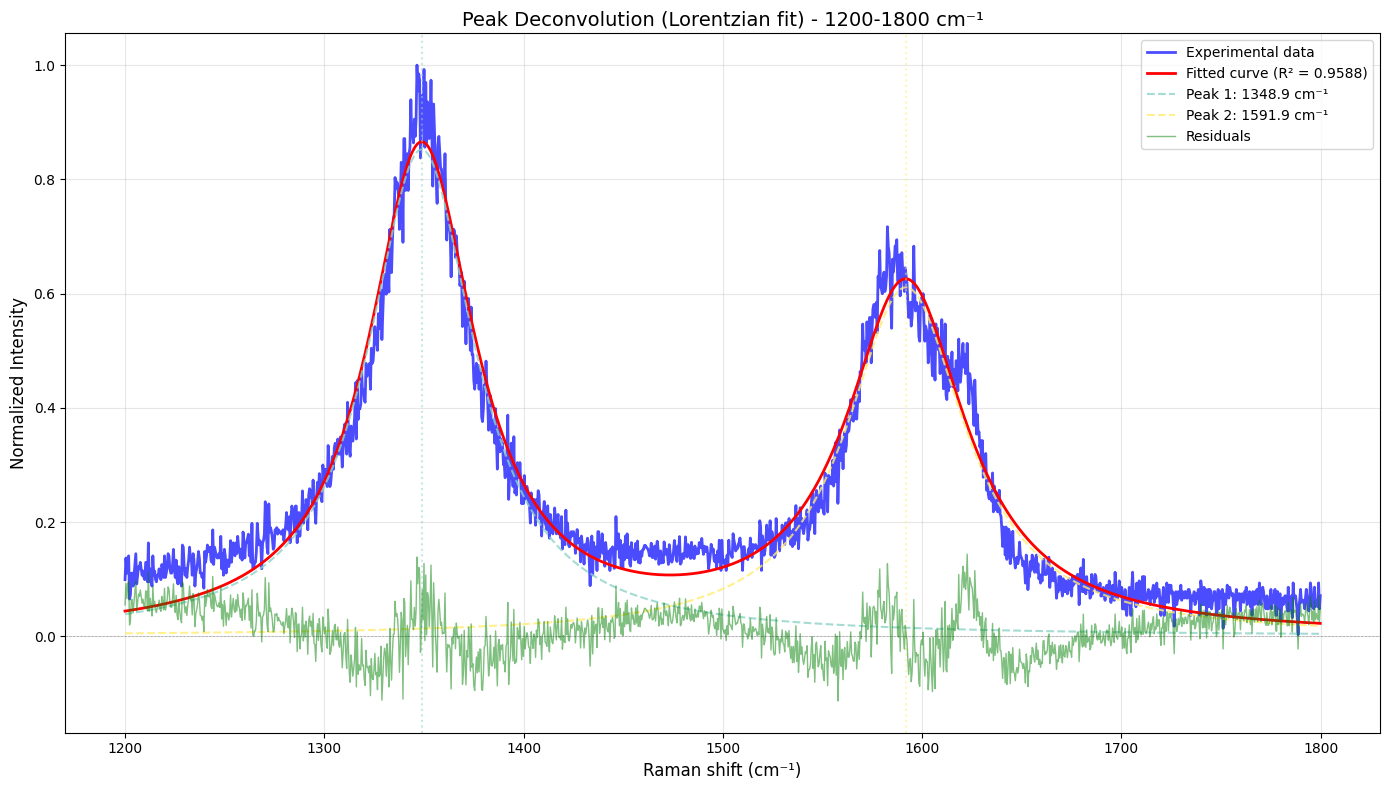

Peak Fitting Results (Lorentzian model)
Region: 1200-1800 cm⁻¹
R² (goodness of fit): 0.9588
 Peak      Center  Amplitude     Width      FWHM      Area
    1 1348.883870   0.852291 32.544122 65.088244 87.138500
    2 1591.868176   0.611018 36.469600 72.939200 70.005982


FITTING 2D BAND REGION



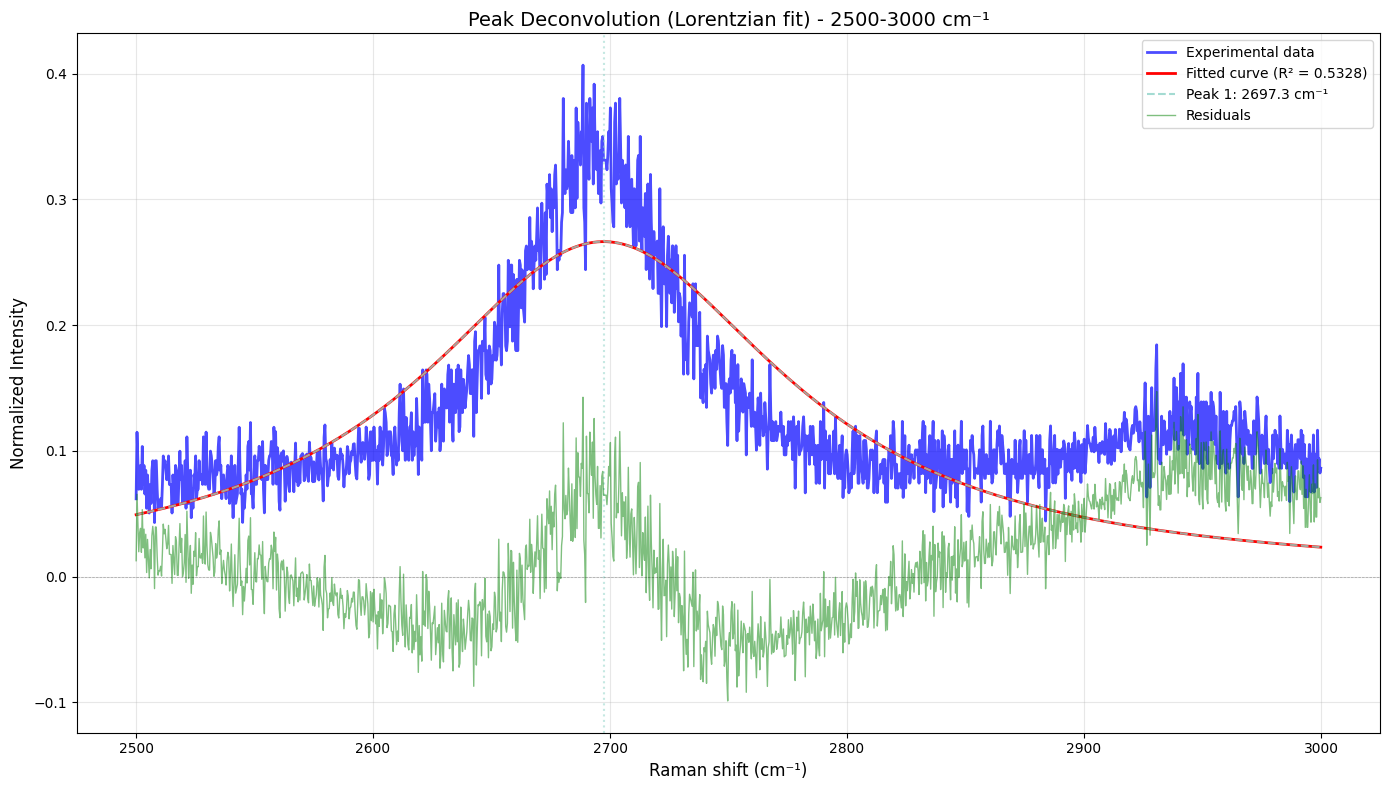

Peak Fitting Results (Lorentzian model)
Region: 2500-3000 cm⁻¹
R² (goodness of fit): 0.5328
 Peak      Center  Amplitude     Width       FWHM      Area
    1 2697.282904   0.266344 93.890273 187.780545 78.562174

MATERIAL QUALITY ANALYSIS

D-band: Center = 1348.9 cm⁻¹, FWHM = 65.1 cm⁻¹
G-band: Center = 1591.9 cm⁻¹, FWHM = 72.9 cm⁻¹

ID/IG ratio (peak height): 1.395
ID/IG ratio (peak area): 1.245

Estimated crystallite size (La): 3.5 nm
Material quality: Lower quality or highly functionalized (high defects)


In [11]:
from scipy.optimize import curve_fit
from scipy.signal import find_peaks

def lorentzian(x, amplitude, center, width):
    """
    Lorentzian (Cauchy) function
    """
    return amplitude / (1 + ((x - center) / width)**2)

def gaussian(x, amplitude, center, width):
    """
    Gaussian function
    """
    return amplitude * np.exp(-((x - center)**2) / (2 * width**2))

def voigt(x, amplitude, center, width_g, width_l):
    """
    Voigt profile (convolution of Gaussian and Lorentzian)
    Approximation using pseudo-Voigt
    """
    fg = gaussian(x, 1, center, width_g)
    fl = lorentzian(x, 1, center, width_l)
    # Pseudo-Voigt mixing parameter
    eta = 0.5
    return amplitude * (eta * fl + (1 - eta) * fg)

def multi_peak_fit(x, *params, peak_type='lorentzian'):
    """
    Sum of multiple peaks
    params: [amp1, center1, width1, amp2, center2, width2, ...]
    """
    n_peaks = len(params) // 3
    y = np.zeros_like(x)
    
    for i in range(n_peaks):
        amp = params[i*3]
        center = params[i*3 + 1]
        width = params[i*3 + 2]
        
        if peak_type == 'lorentzian':
            y += lorentzian(x, amp, center, width)
        elif peak_type == 'gaussian':
            y += gaussian(x, amp, center, width)
    
    return y

def fit_peaks_region(df, region_range, n_peaks, peak_type='lorentzian', 
                     initial_centers=None, plot=True):
    """
    Fit multiple peaks in a specific region
    
    Parameters:
    - df: DataFrame with spectrum
    - region_range: tuple (min_wavenumber, max_wavenumber)
    - n_peaks: number of peaks to fit
    - peak_type: 'lorentzian' or 'gaussian'
    - initial_centers: list of initial peak positions (optional)
    - plot: whether to plot the fit
    
    Returns:
    - fitted_params: fitted parameters
    - fit_quality: R² value
    """
    # Extract region
    mask = (df['Wavenumber'] >= region_range[0]) & (df['Wavenumber'] <= region_range[1])
    x_data = df.loc[mask, 'Wavenumber'].values
    y_data = df.loc[mask, 'Intensity'].values
    
    # Find peaks for initial guess if not provided
    if initial_centers is None:
        peaks, _ = find_peaks(y_data, prominence=0.05)
        if len(peaks) >= n_peaks:
            # Take n_peaks highest peaks
            peak_heights = y_data[peaks]
            top_peak_indices = peaks[np.argsort(peak_heights)[-n_peaks:]]
            initial_centers = sorted(x_data[top_peak_indices])
        else:
            # Distribute evenly
            initial_centers = np.linspace(region_range[0], region_range[1], n_peaks)
    
    # Initial parameters: [amplitude, center, width] for each peak
    initial_params = []
    for center in initial_centers:
        initial_params.extend([
            0.5,  # amplitude
            center,  # center
            20.0  # width
        ])
    
    # Bounds for parameters
    bounds_lower = []
    bounds_upper = []
    for i in range(n_peaks):
        bounds_lower.extend([0.0, region_range[0], 1.0])  # amp, center, width
        bounds_upper.extend([2.0, region_range[1], 100.0])
    
    try:
        # Fit the peaks
        fitted_params, covariance = curve_fit(
            lambda x, *params: multi_peak_fit(x, *params, peak_type=peak_type),
            x_data, y_data,
            p0=initial_params,
            bounds=(bounds_lower, bounds_upper),
            maxfev=10000
        )
        
        # Calculate fit quality (R²)
        y_fitted = multi_peak_fit(x_data, *fitted_params, peak_type=peak_type)
        residuals = y_data - y_fitted
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y_data - np.mean(y_data))**2)
        r_squared = 1 - (ss_res / ss_tot)
        
        # Extract individual peak parameters
        peak_info = []
        for i in range(n_peaks):
            amp = fitted_params[i*3]
            center = fitted_params[i*3 + 1]
            width = fitted_params[i*3 + 2]
            
            # Calculate FWHM (Full Width at Half Maximum)
            if peak_type == 'lorentzian':
                fwhm = 2 * width
            else:  # gaussian
                fwhm = 2.355 * width
            
            # Calculate peak area
            if peak_type == 'lorentzian':
                area = np.pi * amp * width
            else:  # gaussian
                area = amp * width * np.sqrt(2 * np.pi)
            
            peak_info.append({
                'Peak': i + 1,
                'Center': center,
                'Amplitude': amp,
                'Width': width,
                'FWHM': fwhm,
                'Area': area
            })
        
        peak_df = pd.DataFrame(peak_info)
        
        # Plotting
        if plot:
            plt.figure(figsize=(14, 8))
            
            # Original data
            plt.plot(x_data, y_data, 'b-', linewidth=2, label='Experimental data', alpha=0.7)
            
            # Fitted curve
            plt.plot(x_data, y_fitted, 'r-', linewidth=2, label=f'Fitted curve (R² = {r_squared:.4f})')
            
            # Individual peaks
            colors = plt.cm.Set3(np.linspace(0, 1, n_peaks))
            for i in range(n_peaks):
                amp = fitted_params[i*3]
                center = fitted_params[i*3 + 1]
                width = fitted_params[i*3 + 2]
                
                if peak_type == 'lorentzian':
                    y_individual = lorentzian(x_data, amp, center, width)
                else:
                    y_individual = gaussian(x_data, amp, center, width)
                
                plt.plot(x_data, y_individual, '--', color=colors[i], 
                        linewidth=1.5, label=f'Peak {i+1}: {center:.1f} cm⁻¹', alpha=0.8)
                
                # Mark peak center
                plt.axvline(center, color=colors[i], linestyle=':', alpha=0.5)
            
            # Residuals
            plt.plot(x_data, residuals, 'g-', linewidth=1, alpha=0.5, label='Residuals')
            plt.axhline(0, color='black', linestyle='--', linewidth=0.5, alpha=0.3)
            
            plt.xlabel('Raman shift (cm⁻¹)', fontsize=12)
            plt.ylabel('Normalized Intensity', fontsize=12)
            plt.title(f'Peak Deconvolution ({peak_type.capitalize()} fit) - {region_range[0]}-{region_range[1]} cm⁻¹', 
                     fontsize=14)
            plt.legend(fontsize=10, loc='best')
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
        
        # Print results
        print("=" * 70)
        print(f"Peak Fitting Results ({peak_type.capitalize()} model)")
        print(f"Region: {region_range[0]}-{region_range[1]} cm⁻¹")
        print(f"R² (goodness of fit): {r_squared:.4f}")
        print("=" * 70)
        print(peak_df.to_string(index=False))
        print("=" * 70)
        
        return fitted_params, peak_df, r_squared
        
    except RuntimeError as e:
        print(f"Fitting failed: {e}")
        return None, None, None

# Example 1: Fit D and G bands (1200-1800 cm⁻¹)
print("FITTING D AND G BAND REGION")
print()
fitted_params_dg, peak_info_dg, r2_dg = fit_peaks_region(
    df_norm_minmax, 
    region_range=(1200, 1800),
    n_peaks=2,  # D and G bands
    peak_type='lorentzian',
    initial_centers=[1350, 1580]
)

# Example 2: Fit 2D band region (2500-3000 cm⁻¹)
print("\n\nFITTING 2D BAND REGION")
print()
fitted_params_2d, peak_info_2d, r2_2d = fit_peaks_region(
    df_norm_minmax,
    region_range=(2500, 3000),
    n_peaks=1,  # Single 2D band
    peak_type='lorentzian',
    initial_centers=[2700]
)

# Calculate ID/IG ratio from fitted peak areas
if peak_info_dg is not None:
    print("\n" + "=" * 70)
    print("MATERIAL QUALITY ANALYSIS")
    print("=" * 70)
    
    d_band_info = peak_info_dg[peak_info_dg['Center'] < 1450].iloc[0]
    g_band_info = peak_info_dg[peak_info_dg['Center'] > 1450].iloc[0]
    
    id_ig_height = d_band_info['Amplitude'] / g_band_info['Amplitude']
    id_ig_area = d_band_info['Area'] / g_band_info['Area']
    
    print(f"\nD-band: Center = {d_band_info['Center']:.1f} cm⁻¹, FWHM = {d_band_info['FWHM']:.1f} cm⁻¹")
    print(f"G-band: Center = {g_band_info['Center']:.1f} cm⁻¹, FWHM = {g_band_info['FWHM']:.1f} cm⁻¹")
    print(f"\nID/IG ratio (peak height): {id_ig_height:.3f}")
    print(f"ID/IG ratio (peak area): {id_ig_area:.3f}")
    
    # Estimate crystallite size using Tuinstra-Koenig relation
    # La (nm) ≈ 4.4 / (ID/IG) for 514 nm laser
    # This is approximate - adjust constant for your laser wavelength
    la = 4.4 / id_ig_area
    print(f"\nEstimated crystallite size (La): {la:.1f} nm")
    
    if id_ig_area < 0.8:
        quality = "High quality (low defects)"
    elif id_ig_area < 1.2:
        quality = "Good quality (moderate defects)"
    else:
        quality = "Lower quality or highly functionalized (high defects)"
    
    print(f"Material quality: {quality}")
    print("=" * 70)